## CHEME 5660: Using Single Index Models and Boltzmann Weighted Data in Markowitz Portfolio Allocation

### Introduction
Fill me in.

### Example setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-SIM-Boltzmann-Markowitz-notebook`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-SIM-Boltzmann-Markowitz-notebook/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-SIM-Boltzmann-Markowitz-notebook/Manifest.toml`


In [2]:
# load req packages -
using Convex
using SCS
using DataFrames
using Dates
using Colors
using Plots
using StatsPlots
using Statistics
using MathOptInterface
using FileIO
using JLD2
using PrettyTables
using Distributions
using LinearAlgebra

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");

In [3]:
include("Example-SIM-Boltzmann-Markowitz-CodeLib.jl");

In [4]:
# daily risk-free rate -
r̄ = 0.0403;
risk_free_daily = ((1+r̄)^(1/365) - 1);

# how many days of historical data are we using?
m̂ = 596;
λ̂ = 0.001;

# 596

# step hist parameters -
number_of_bins = 80;

In [5]:
# load the JLD2 portfolio data file -
tmp = load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-10-30-22.jld2"))["dd"];

In [6]:
# how many elements do we have in SPY?
spy_df_length = length(tmp["SPY"][!,:close]);

# go through each of the tickers and *remove* tickers that don't have the same length as SPY -
price_data_dictionary = Dict{String, DataFrame}();
for (ticker, test_df) ∈ tmp
    
    # how long is test_df?
    test_df_length = length(test_df[!,:close])
    if (test_df_length == spy_df_length)
       price_data_dictionary[ticker] = test_df; 
    else
        println("Length violation: $(ticker) was removed; dim(SPY) = $(spy_df_length) days and dim($(ticker)) = $(test_df_length) days")
    end
end

# we have these ticker symbols in our data set -
ticker_symbol_array = sort(keys(price_data_dictionary) |> collect);

# How many tickers do we have?
Nₐ = length(ticker_symbol_array);

Length violation: META was removed; dim(SPY) = 597 days and dim(META) = 247 days
Length violation: BIIB was removed; dim(SPY) = 597 days and dim(BIIB) = 596 days


In [7]:
# Compute (and visualize) same returns w and w/o weights -
ticker_to_explore = "MU"
(R, R̂, W, μᵦ, pᵦ) = compute_excess_return(price_data_dictionary[ticker_to_explore]; m = m̂, rf = risk_free_daily, λ = λ̂);

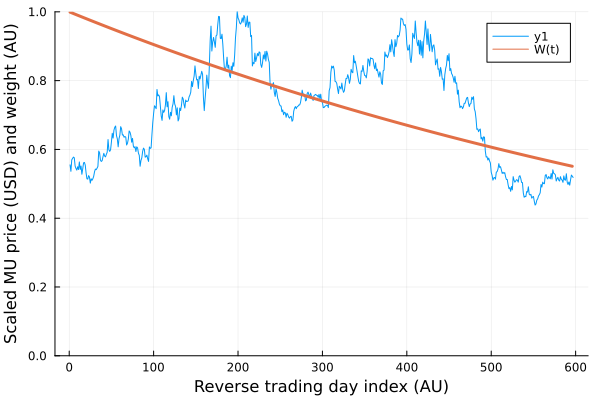

In [8]:
# grab data -
test_data = sort(price_data_dictionary[ticker_to_explore], [order(:timestamp, rev=true), :close]);

Sₒ = maximum(test_data[!, :close])
S = test_data[!, :close]

plot(S./Sₒ, ylim=(0.0,1.0))
plot!(W, lw=3, label="W(t)")

xlabel!("Reverse trading day index (AU)", fontsize=18)
ylabel!("Scaled $(ticker_to_explore) price (USD) and weight (AU)", fontsize=18)

In [9]:
println("mean R = $(mean(R)) and E(R̂) = $(μᵦ)")

mean R = 0.013403026122356096 and E(R̂) = -0.014615907561514254


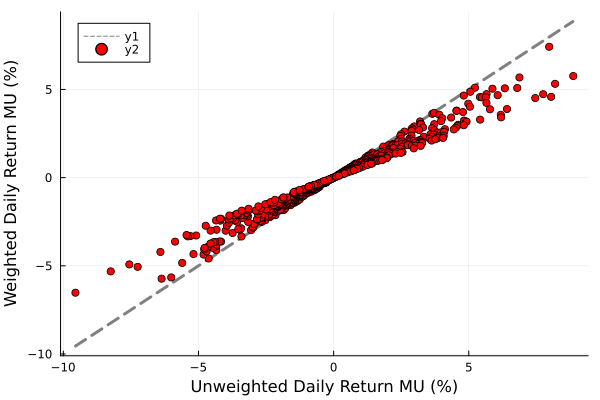

In [10]:
L = minimum(R);
U = maximum(R);

Z = range(L,stop=U,step=0.1) |> collect;
plot(Z,Z,lw=3, c=:gray, ls=:dash, legend=:topleft)
scatter!(R,R̂, c=:red)
xlabel!("Unweighted Daily Return $(ticker_to_explore) (%)", fontsize=18)
ylabel!("Weighted Daily Return $(ticker_to_explore) (%)", fontsize=18)

### b) Estimate SIMs for each asset in our collection

#### Phase 1: Estimate $\left(\alpha_{i}, \beta_{i}\right)$ usind direct matrix inversion

In [11]:
# initialize -
sim_model_dictionary = Dict{String, SingleIndexModel}();

# compute the excess nreturn for SPY (which is in the data set)
(Rₘ, R̂ₘ, W, μᵦ, pᵦ) = compute_excess_return(price_data_dictionary["SPY"]; 
    m = m̂, rf = risk_free_daily, λ = λ̂);

# main loop -
for i ∈ 1:Nₐ
    
    # grab a ticker -
    asset_ticker = ticker_symbol_array[i];
    
    # compute the excess return for asset_ticker -
    (Rᵢ, R̂ᵢ, W, μᵦ, pᵦ) = compute_excess_return(price_data_dictionary[asset_ticker]; 
        m = m̂, rf = risk_free_daily, λ = λ̂);
    
    # formulate the Y and X arrays with the price data -
    max_length = length(R̂ᵢ);
    Y = R̂ᵢ;
    X = [ones(max_length) R̂ₘ];
    
    # compute θ -
    θ = inv(transpose(X)*X)*transpose(X)*Y
    
    # package -
    sim_model = SingleIndexModel();
    sim_model.α = θ[1];
    sim_model.β = θ[2];
    sim_model.r = risk_free_daily;
    sim_model_dictionary[asset_ticker] = sim_model;
end

#### Phase 2: Estimate the error models $\epsilon\left(t\right)$

In [12]:
# compute the error model -

# main loop -
for i ∈ 1:Nₐ
    
    # grab a ticker -
    asset_ticker = ticker_symbol_array[i];
    
    # grab the model -
    sim_model = sim_model_dictionary[asset_ticker];
    
    # compute the excess return for asset_ticker (data) -
    (Rᵢ, R̂ᵢ, W, μᵦ, pᵦ) = compute_excess_return(price_data_dictionary[asset_ticker];  
        m = m̂, rf = risk_free_daily, λ = λ̂);
        
    # compute the model excess return -
    αᵢ = sim_model.α
    βᵢ = sim_model.β
    R_prediction = αᵢ .+ βᵢ .* R̂ₘ
    
    # compute the residual -
    Δ = R̂ᵢ .- R_prediction;
    
    # Esimate a distribution -
    d = fit_mle(Normal, Δ);
    
    # update the sim_model -
    sim_model.ϵ = d;
end

##### Visualize SIM performance

In [13]:
# pick an asset -
asset_ticker = "AMD"
sim_model = sim_model_dictionary[asset_ticker];

# compute the excess return for asset_ticker (data) -
(Rᵢ, R̂ᵢ, W, μᵦ, pᵦ) = compute_excess_return(price_data_dictionary[asset_ticker]; 
    rf = risk_free_daily, m = m̂, λ = λ̂);

# evaluate the SIM (without noise) -
R̂_model = evaluate_model(sim_model, sort(R̂ₘ));

# sample the SIM to get the uncertainty region -
R̂_samples = sample_sim_model(sim_model, sort(R̂ₘ); 𝒫 = 1000);

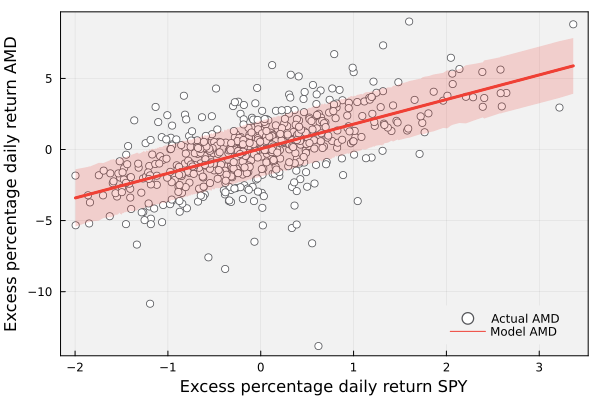

In [14]:
# data and expected value -
scatter(R̂ₘ, R̂ᵢ, mc=colorant"#FFFFFF", msc=colorant"#55565A", label="Actual $(asset_ticker)", legend=:bottomright)

# uncertainty region -
L = R̂_model .- std(R̂_samples,dims=2)
U = R̂_model .+ std(R̂_samples,dims=2)

plot!(sort(R̂ₘ), R̂_model, fillrange=U, fillalpha = 0.2, lw=2, label="", c=colorant"#EF4035")
plot!(sort(R̂ₘ), R̂_model, fillrange=L, fillalpha = 0.2, lw=2, label="", c=colorant"#EF4035")

plot!(sort(R̂ₘ), R̂_model, lw=3, c=colorant"#EF4035", bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, label="Model $(asset_ticker)")


# labels -
xlabel!("Excess percentage daily return SPY",fontsize=18)
ylabel!("Excess percentage daily return $(asset_ticker)",fontsize=18)

# uncomment me to save figure to disk -
#filename = "Fig-SIM-$(asset_ticker)-m-200-11-3-2022.pdf";
#savefig(joinpath(_PATH_TO_FIGS, filename));

### c) Markowitz Allocation using Single Index Models of Risk and Return

In [15]:
# compute the μ_vector -
μ_vector = μ(sim_model_dictionary, R̂ₘ, ticker_symbol_array);

In [16]:
# compute Σ -
Σ_array = Σ(sim_model_dictionary, R̂ₘ, ticker_symbol_array);

In [17]:
# define the returns that we are going to simulate -
target_return_array = 100 .*range(0.0, step=0.0001, stop = 0.003) |> collect # percentage
L = length(target_return_array);

In [18]:
# Initialize MinVar array
# row: return
# col 1 -> risk
# col 2 -> return
# col 3 ... N -> allocation
MinVarArray = Array{Float64,2}(undef,L, (Nₐ + 2));

# main loop: pick a return, run the calculation. If solver converged, store results
for i = 1:L

    tr = target_return_array[i]
    (status_flag, ω, opt_val, ret_val) = compute_minvar_portfolio_allocation(μ_vector, Σ_array, tr; w_lower = 0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        
        MinVarArray[i,1] = opt_val;
        MinVarArray[i,2] = ret_val;
        
        # capture the allocation
        for a ∈ 1:Nₐ
            MinVarArray[i,2+a] = ω[a]
        end
    end
end

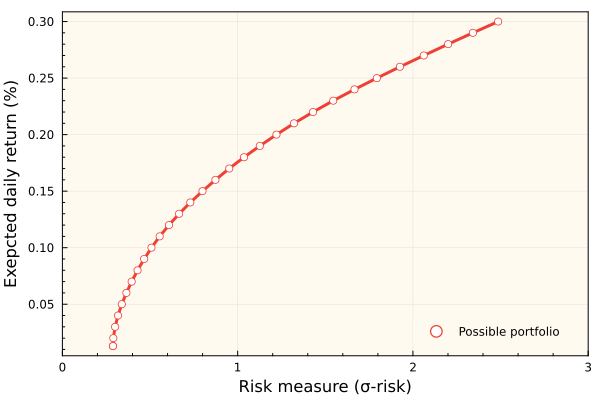

In [19]:
# pull out the risk and rerturn -
risk_array = sqrt.(MinVarArray[:,1])
return_array = MinVarArray[:,2];

# plot -
plot(risk_array, return_array, label="", c=colorant"#EF4035", legend=:bottomright, bg="floralwhite", 
background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=3, xlim=(0.0,3.0),minorticks=0.1)
scatter!(risk_array, return_array, label="Possible portfolio", mc=:white, msc=colorant"#EF4035")
xlabel!("Risk measure (σ-risk)", fontsize=18)
ylabel!("Exepcted daily return (%)", fontsize=18)

### d) Markowitz Allocation using Single Index Models of Risk and Return (risky+risk-free)

In [20]:
# Initialize MinVarRiskFree array
# row: return
# col 1 -> risk
# col 2 -> return
# col 3 ... N -> allocation
MinVarRiskFreeArray = Array{Float64,2}(undef, L, (Nₐ + 2));

# main loop: pick a return, run the calculation. If solver converged, store results
for i = 1:L

    tr = target_return_array[i]
    (status_flag, ω, opt_val, ret_val) = compute_minvar_portfolio_allocation_risk_free(μ_vector, Σ_array, tr;
        risk_free_return = risk_free_daily, w_lower =  0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        
        # capture the risk and reward values -
        MinVarRiskFreeArray[i,1] = opt_val;
        MinVarRiskFreeArray[i,2] = ret_val;
        
        # capture the allocation
        for a ∈ 1:Nₐ
            MinVarRiskFreeArray[i,2+a] = ω[a]
        end
    end
end

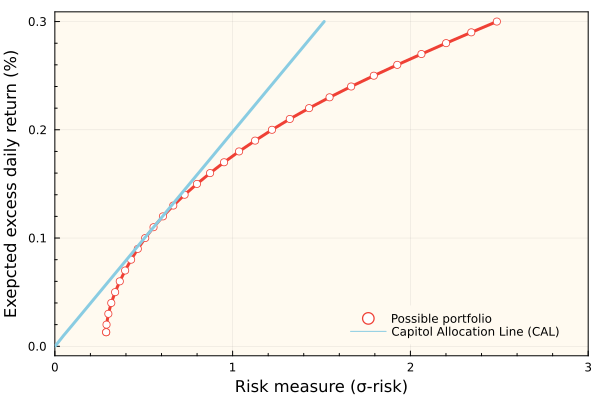

In [24]:
# pull out the risk and rerturn for the risk-free case -
risk_array_rf = sqrt.(MinVarRiskFreeArray[:,1])
return_array_rf = MinVarRiskFreeArray[:,2];

# plot the risk-only portfolio -
plot(risk_array, return_array, label="", c=colorant"#EF4035", legend=:bottomright, bg="floralwhite", 
background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=3, minorticks=0.05, xlim=(0.0,3.0))
scatter!(risk_array, return_array, label="Possible portfolio", mc=:white, msc=colorant"#EF4035")

# plot the CAL -

plot!(risk_array_rf,  return_array_rf, lw=3, c=colorant"#89CCE2", label="Capitol Allocation Line (CAL)")

# axis labels -
xlabel!("Risk measure (σ-risk)", fontsize=18)
ylabel!("Exepcted excess daily return (%)", fontsize=18)

In [27]:
# make a allocation table for risky+risk free asset case -

# what portfolio index do we need?
portfolio_index_rf = findall(x->x<=0.52, risk_array_rf)[end]
δ = 0.005; # what is my cutoff?

# find the indexes of the assets that are "not small" -
idx_not_small_rf = findall(x-> abs(x) >= δ, MinVarRiskFreeArray[portfolio_index_rf,3:end])
A = length(idx_not_small_rf);

# setup table -
allocation_table_data_rf = Array{Any,2}(undef, A+1, 4);
for a ∈ 1:A
    
    # grab the data -
    idx = idx_not_small_rf[a];
    ticker = ticker_symbol_array[idx]
    ωₐ = MinVarRiskFreeArray[portfolio_index_rf,(idx .+ 2)];

    # package -
    allocation_table_data_rf[a,1] = ticker;
    allocation_table_data_rf[a,2] = ωₐ
    allocation_table_data_rf[a,3] = μ_vector[idx];
    allocation_table_data_rf[a,4] = Σ_array[idx,idx];
end

# add a total row -
allocation_table_data_rf[end,1] = "Total"
allocation_table_data_rf[end,2] = sum(MinVarRiskFreeArray[portfolio_index_rf, (idx_not_small_rf .+ 2)])
allocation_table_data_rf[end,3] = MinVarRiskFreeArray[portfolio_index_rf,2];
allocation_table_data_rf[end,4] = sqrt.(MinVarRiskFreeArray[portfolio_index_rf,1])

# header -
allocation_table_header_rf = (["Ticker", "weight", "E(r)", "σ"])

# show the table -
pretty_table(allocation_table_data_rf; header = allocation_table_header_rf)

┌────────┬────────────┬───────────┬──────────┐
│ Ticker │     weight │      E(r) │        σ │
├────────┼────────────┼───────────┼──────────┤
│     BA │  0.0322438 │ 0.0484539 │  4.63949 │
│    BIO │ 0.00942986 │ 0.0129218 │  2.58175 │
│      C │  0.0102142 │ 0.0130942 │  2.46994 │
│    CLX │   0.071793 │ 0.0522179 │  1.83546 │
│    CRM │ 0.00919789 │ 0.0164664 │   3.6053 │
│   INTC │   0.097475 │  0.092838 │  3.15581 │
│    KMB │  0.0372646 │ 0.0137982 │  0.87797 │
│    MMM │  0.0372844 │  0.017444 │   1.2046 │
│   NFLX │  0.0317416 │ 0.0759933 │  6.74323 │
│    SWK │  0.0706591 │ 0.0457692 │  2.14582 │
│      T │   0.112911 │ 0.0594125 │  1.44536 │
│    VXX │   0.182947 │  0.346578 │  10.1027 │
│     VZ │   0.159177 │ 0.0384073 │ 0.663805 │
│    WBA │   0.013832 │ 0.0158074 │  2.46984 │
│    XPO │  0.0257904 │ 0.0761392 │  8.29912 │
│  Total │   0.901961 │ 0.0999972 │ 0.504602 │
└────────┴────────────┴───────────┴──────────┘
